In [1]:
import os
import pandas as pd
import numpy as np
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly as py
import plotly.graph_objs as go
import gensim
from gensim import corpora, models, similarities
import logging
import tempfile
from nltk.corpus import stopwords
from string import punctuation
from collections import OrderedDict
import seaborn as sns
import pyLDAvis.gensim
import matplotlib.pyplot as plt
%matplotlib inline

init_notebook_mode(connected=True) #do not miss this line

import warnings
warnings.filterwarnings("ignore")

In [2]:
datafile = '../input/data_elonmusk.csv'

In [3]:
import pandas as pd
tweets = pd.read_csv(datafile, encoding='latin1')
tweets = tweets.assign(Time=pd.to_datetime(tweets.Time)).drop('row ID', axis='columns')

print("Number of tweets: ",len(tweets['Tweet']))
tweets.head(5)

Number of tweets:  3218


,Tweet,Time,Retweet from,User
0,@MeltingIce Assuming max acceleration of 2 to ...,2017-09-29 17:39:19,NaN,elonmusk
1,RT @SpaceX: BFR is capable of transporting sat...,2017-09-29 10:44:54,SpaceX,elonmusk
2,@bigajm Yup :),2017-09-29 10:39:57,NaN,elonmusk
3,Part 2 https://t.co/8Fvu57muhM,2017-09-29 09:56:12,NaN,elonmusk
4,Fly to most places on Earth in under 30 mins a...,2017-09-29 09:19:21,NaN,elonmusk


***Tweet Activity Over Years***

In [4]:
'''import plotly.plotly as py
import plotly.graph_objs as go
'''
tweets['Time'] = pd.to_datetime(tweets['Time'], format='%y-%m-%d %H:%M:%S')
tweetsT = tweets['Time']

trace = go.Histogram(
    x=tweetsT,
    marker=dict(
        color='blue'
    ),
    opacity=0.75
)

layout = go.Layout(
    title='Tweet Activity Over Years',
    height=450,
    width=1200,
    xaxis=dict(
        title='Month and year'
    ),
    yaxis=dict(
        title='Tweet Quantity'
    ),
    bargap=0.2,
)

data = [trace]

fig = go.Figure(data=data, layout=layout)
py.offline.iplot(fig)

In [5]:
# Preparing a corpus for analysis and checking first 10 entries

corpus=[]
a=[]
for i in range(len(tweets['Tweet'])):
        a=tweets['Tweet'][i]
        corpus.append(a)
        
corpus[0:10]

["@MeltingIce Assuming max acceleration of 2 to 3 g's, but in a comfortable direction. Will feel like a mild to moder? https://t.co/fpjmEgrHfC",
 'RT @SpaceX: BFR is capable of transporting satellites to orbit, crew and cargo to the @Space_Station and completing missions to the Moon an?',
 '@bigajm Yup :)',
 'Part 2 https://t.co/8Fvu57muhM',
 'Fly to most places on Earth in under 30 mins and anywhere in under 60. Cost per seat should be? https://t.co/dGYDdGttYd',
 'RT @SpaceX: Supporting the creation of a permanent, self-sustaining human presence on Mars. https://t.co/kCtBLPbSg8 https://t.co/ra6hKsrOcG',
 'BFR will take you anywhere on Earth in less than 60 mins https://t.co/HWt9BZ1FI9',
 'Mars City\nOpposite of Earth. Dawn and dusk sky are blue on Mars and day sky is red. https://t.co/XHcZIdgqnb',
 'Moon Base Alpha https://t.co/voY8qEW9kl',
 "Will be announcing something really special at today's talk https://t.co/plXTBJY6ia"]

In [6]:
TEMP_FOLDER = tempfile.gettempdir()
print('Folder "{}" will be used to save temporary dictionary and corpus.'.format(TEMP_FOLDER))

logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

Folder "/tmp" will be used to save temporary dictionary and corpus.


In [7]:
# removing common words and tokenizing
list1 = ['RT','rt']
stoplist = stopwords.words('english') + list(punctuation) + list1

texts = [[word for word in str(document).lower().split() if word not in stoplist] for document in corpus]

dictionary = corpora.Dictionary(texts)
dictionary.save(os.path.join(TEMP_FOLDER, 'elon.dict'))  # store the dictionary, for future reference

#print(dictionary)
#print(dictionary.token2id)

In [8]:
corpus = [dictionary.doc2bow(text) for text in texts]
corpora.MmCorpus.serialize(os.path.join(TEMP_FOLDER, 'elon.mm'), corpus)  # store to disk, for later use

In the previous cells, I created a corpus of documents represented as a stream of vectors. To continue, lets use that corpus, with the help of Gensim.

### Creating a transformation


The transformations are standard Python objects, typically initialized by means of a training corpus:

Different transformations may require different initialization parameters; in case of TfIdf, the “training” consists simply of
going through the supplied corpus once and computing document frequencies of all its features.
Training other models, such as Latent Semantic Analysis or Latent Dirichlet Allocation, is much more involved and,
consequently, takes much more time.

In [9]:
tfidf = models.TfidfModel(corpus) # step 1 -- initialize a model

### Note
Transformations always convert between two specific vector spaces. The same vector space (= the same set of feature ids) must be used for training as well as for subsequent vector transformations. Failure to use the same input feature space, such as applying a different string preprocessing, using different feature ids, or using bag-of-words input vectors where TfIdf vectors are expected, will result in feature mismatch during transformation calls and consequently in either garbage output and/or runtime exceptions.

From now on, tfidf is treated as a read-only object that can be used to apply a transformation to a whole corpus:

In [10]:
corpus_tfidf = tfidf[corpus]  # step 2 -- use the model to transform vectors

### LDA:
https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation

Latent Dirichlet Allocation, LDA is yet another transformation from bag-of-words counts into a topic space of lower dimensionality. LDA is a probabilistic extension of LSA (also called multinomial PCA), so LDA’s topics can be interpreted as probability distributions over words. These distributions are, just like with LSA, inferred automatically from a training corpus. Documents are in turn interpreted as a (soft) mixture of these topics (again, just like with LSA).

In [11]:
total_topics = 5

In [12]:
lda = models.LdaModel(corpus, id2word=dictionary, num_topics=total_topics)
corpus_lda = lda[corpus_tfidf] # create a double wrapper over the original corpus: bow->tfidf->fold-in-lsi

In [13]:
#Show first n important word in the topics:
lda.show_topics(total_topics,5)

[(0,
  '0.009*"tesla" + 0.006*"model" + 0.006*"like" + 0.005*"good" + 0.005*"launch"'),
 (1,
  '0.010*"tesla" + 0.005*"good" + 0.004*"car" + 0.004*"@spacex" + 0.004*"model"'),
 (2,
  '0.009*"tesla" + 0.007*"model" + 0.004*"@spacex:" + 0.004*"launch" + 0.004*"falcon"'),
 (3,
  '0.009*"tesla" + 0.007*"launch" + 0.006*"falcon" + 0.006*"next" + 0.005*"rocket"'),
 (4,
  '0.013*"model" + 0.006*"w" + 0.005*"car" + 0.004*"rocket" + 0.004*"@elonmusk"')]

In [14]:
data_lda = {i: OrderedDict(lda.show_topic(i,25)) for i in range(total_topics)}
#data_lda

In [15]:
df_lda = pd.DataFrame(data_lda)
df_lda = df_lda.fillna(0).T
print(df_lda.shape)

(5, 74)


In [16]:
df_lda

,tesla,model,like,good,launch,rocket,video,:),@teslamotors:,falcon,...,"yes,",3,yes,going,due,mars,vs,electric,people,f9
0,0.008987,0.006048,0.005718,0.004971,0.004639,0.004579,0.004148,0.003821,0.003634,0.003383,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.009645,0.003815,0.003758,0.005019,0.000000,0.002265,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.009234,0.007280,0.003504,0.001925,0.004036,0.003232,0.000000,0.000000,0.001959,0.003531,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.009273,0.000000,0.000000,0.000000,0.007185,0.004888,0.000000,0.000000,0.000000,0.005828,...,0.002112,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.003587,0.012911,0.002119,0.000000,0.002671,0.004028,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.003726,0.002888,0.002839,0.002211,0.002109,0.001897,0.001829,0.001788,0.001757


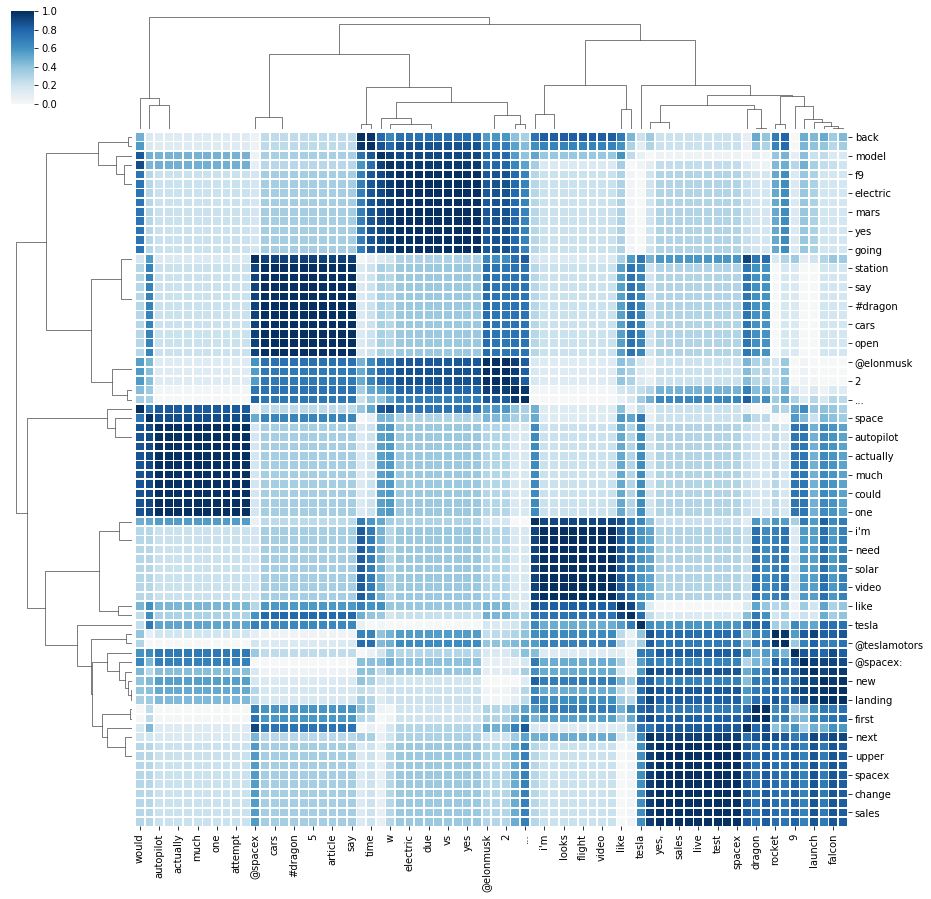

In [17]:
g=sns.clustermap(df_lda.corr(), center=0, standard_scale=1, cmap="RdBu", metric='cosine', linewidths=.75, figsize=(15, 15))
plt.setp(g.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
plt.show()
#plt.setp(ax_heatmap.get_yticklabels(), rotation=0)  # For y axis

In [18]:
pyLDAvis.enable_notebook()
panel = pyLDAvis.gensim.prepare(lda, corpus_lda, dictionary, mds='tsne')
panel

PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
4       22.852821   -6.608855       1        1  59.747471
1      -19.938435 -125.058418       2        1  10.134290
0       98.739426 -152.181122       3        1  10.052328
3      209.481155 -101.618301       4        1  10.044363
2      143.610321    5.724133       5        1  10.021552, topic_info=    Category       Freq           Term      Total  loglift  logprob
231  Default  18.000000          tesla  18.000000  30.0000  30.0000
329  Default  10.000000         launch  10.000000  29.0000  29.0000
10   Default   8.000000           like   8.000000  28.0000  28.0000
82   Default   7.000000         falcon   7.000000  27.0000  27.0000
580  Default  30.000000          model  30.000000  26.0000  26.0000
..       ...        ...            ...        ...      ...      ...
407   Topic5   0.758896              w  12.087813  -0.4677  -6.0520
314   Topic5   0.631617  @teslamotors:   4.790048   0.2744  -6.2356
147   Topic5   0.620663           good   6.088399   0.0171  -6.2530
383   Topic5   0.564919             us   2.770810   0.7102  -6.3472
471   Topic5   0.571420      autopilot   3.565859   0.4694  -6.3357

[371 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
1013      2  0.959073  #dragon
7934      1  1.008279     (not
2277      1  1.009958       --
272       1  0.637843      ...
272       2  0.127569      ...
...     ...       ...      ...
160       3  0.131182    would
160       5  0.131182    would
153       1  0.988304      yes
144       1  0.566643     yes,
144       4  0.283321     yes,

[263 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 2, 1, 4, 3])